In [2]:
# Pneumonia Detection from Chest X-Rays using InceptionV3

In [3]:
!pip install medmnist torch torchvision matplotlib seaborn pandas numpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00


In [4]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# Load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

100%|██████████| 4.17M/4.17M [00:00<00:00, 6.21MB/s]


In [7]:
# Print dataset information
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("Number of channels:", n_channels)
print("Number of classes:", n_classes)
print("Task:", task)

Train dataset size: 4708
Test dataset size: 624
Number of channels: 1
Number of classes: 2
Task: binary-class


In [8]:
# Data preprocessing and augmentation
data_transform = transforms.Compose([
    transforms.Resize((299, 299)), # Resize for InceptionV3
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5]) # Adjust mean and std for 3 channels
])

# No augmentation for validation and test sets, only resizing and normalization
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5]) # Adjust mean and std for 3 channels
])

train_dataset.transform = data_transform
test_dataset.transform = test_transform

# Create data loaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained InceptionV3 model
model = models.inception_v3(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name: # Unfreeze the fully connected layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the output layer for binary classification (2 classes)
# InceptionV3 has an auxiliary output, so we need to modify both the main and auxiliary heads
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)

# Modify the auxiliary output layer as well
if model.aux_logits:
    num_aux_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_aux_ftrs, n_classes)


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model defined and moved to:", device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 141MB/s] 


Model defined and moved to: cuda


In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training loop
num_epochs = 10  # You can adjust this
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # InceptionV3 returns main output and auxiliary output during training
        outputs, aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels.squeeze())
        loss2 = criterion(aux_outputs, labels.squeeze())
        loss = loss1 + 0.4 * loss2 # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training finished.")

Epoch 1/10, Loss: 0.5907
Epoch 2/10, Loss: 0.4284
Epoch 3/10, Loss: 0.3947
Epoch 4/10, Loss: 0.3793
Epoch 5/10, Loss: 0.3666
Epoch 6/10, Loss: 0.3684
Epoch 7/10, Loss: 0.3651
Epoch 8/10, Loss: 0.3618
Epoch 9/10, Loss: 0.3499
Epoch 10/10, Loss: 0.3476
Training finished.


In [12]:
# Model evaluation
model.eval()
running_corrects = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # InceptionV3 returns a tuple of (output, auxiliary_output) during evaluation
        # We only need the main output for evaluation
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7885
Precision: 0.7601
Recall: 0.9667
F1-score: 0.8510
Confusion Matrix:
[[115 119]
 [ 13 377]]


In [13]:
# Analyze class distribution in the training dataset
train_labels = [label for _, label in train_dataset]
class_counts = pd.Series(train_labels).value_counts().sort_index()

print("Class distribution in the training dataset:")
print(class_counts)

# Calculate and print the percentages
total_samples = len(train_labels)
class_percentages = (class_counts / total_samples) * 100
print("\nClass percentages in the training dataset:")
print(class_percentages)

Class distribution in the training dataset:
[0]    1214
[1]    3494
Name: count, dtype: int64

Class percentages in the training dataset:
[0]    25.785896
[1]    74.214104
Name: count, dtype: float64


In [14]:
!pip freeze > requirements.txt

Number of misclassified cases: 132


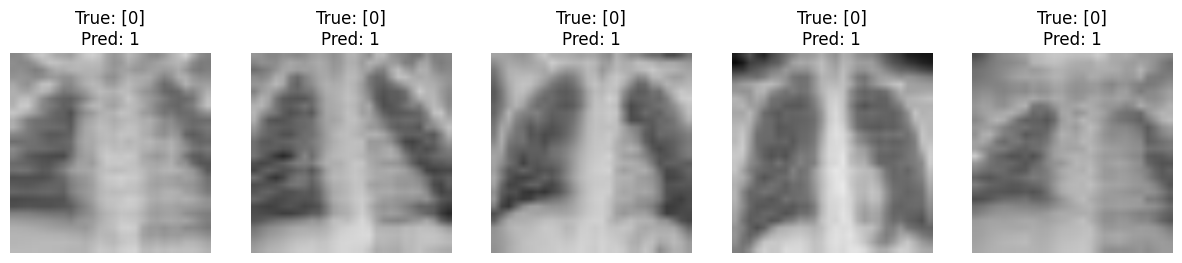

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels for the test set
all_preds = []
all_labels = []
all_inputs = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0] # Get main output for InceptionV3

        _, preds = torch.max(outputs, 1)

        all_inputs.extend(inputs.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Identify misclassified indices
misclassified_indices = [i for i, (label, pred) in enumerate(zip(all_labels, all_preds)) if label != pred]

print(f"Number of misclassified cases: {len(misclassified_indices)}")

# Display a few misclassified examples
num_display = 5 # Number of misclassified examples to display
if len(misclassified_indices) > 0:
    plt.figure(figsize=(15, 5))
    for i in range(min(num_display, len(misclassified_indices))):
        index = misclassified_indices[i]
        input_img = all_inputs[index]
        true_label = all_labels[index]
        predicted_label = all_preds[index]

        # Denormalize the image for display
        # Assuming normalization with mean=[.5,.5,.5] and std=[.5,.5,.5]
        img_display = input_img * 0.5 + 0.5
        img_display = np.clip(img_display.permute(1, 2, 0), 0, 1) # Rearrange dimensions for matplotlib

        plt.subplot(1, num_display, i + 1)
        plt.imshow(img_display)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()
else:
    print("No misclassified cases found in the test set.")